In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

#🧑‍🍳**Preparing The Data**

**Used this [PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071) Research Paper for the Project Analysis and Insights ,and Used their Provided data for further model building.The data used is -> [Here](https://github.com/Franck-Dernoncourt/pubmed-rct)**



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


🎯**Using the 20K Version for analysis and detection of key insights from the data and trying to find a resonable accuracy with our model before going to 200k version.**

In [ ]:
import os
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
file_names = [data_dir + file_name for file_name in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
data = get_line(file_names[1])
data[:2]

[b'###24845963\n',
 b'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n']

##🍽️**Data Refining**

**This Functions Helps to turn all the raw data into organised form of dictionary where we will have**
*   **line_number**:*Tells which line number it is in the given paragraph.*
*   **label**:*tells what label it's classified into.*
*   **string**:*The actual string used for the classification.*
*   **total_lines**:*Tells the total line in the particular paragraph.*

**This format of data is very helpful for more advance training of the model.**

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["label"] = target_text_split[0] # get target label
        line_data["string"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
ref_train_data = preprocess_text_with_line_numbers(file_names[0])
ref_test_data = preprocess_text_with_line_numbers(file_names[1])
ref_val_data = preprocess_text_with_line_numbers(file_names[2])

In [ ]:
import pandas as pd
train_data = pd.DataFrame(ref_train_data)
test_data = pd.DataFrame(ref_test_data)
val_data = pd.DataFrame(ref_val_data)

In [ ]:
train_data

,label,string,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


*One Hot Encoded Labels*

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
train_label_ohe = ohe.fit_transform(train_data['label'].to_numpy().reshape(-1, 1))
test_label_ohe = ohe.transform(test_data['label'].to_numpy().reshape(-1, 1))
val_label_ohe = ohe.transform(val_data['label'].to_numpy().reshape(-1, 1))

*Label Encoded labels*

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_label_le = le.fit_transform(train_data['label'])
test_label_le = le.fit_transform(test_data['label'])
val_label_le = le.fit_transform(val_data['label'])

In [ ]:
ohe.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

##🧪**Model Evaluation Methods**
####**A function to measure various metrics of a model**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
def eval_model(y_true,y_pred,avg='weighted'):
  """
    Args:
      -> y_pred: predicted outcomes of the model
      -> y_true: actual labels/values of the data on which predictions is made
      -> avg[default = weighted(for multiclass)]: binary for binary classification
    Returns:
      ->dict_ : a pandas dataframe of several metrics.
  """
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred,average=avg)
  recall = recall_score(y_true, y_pred,average=avg)
  f1 = f1_score(y_true, y_pred,average=avg)
  dict_ = {
      "accuracy":accuracy,
      "precision":precision,
      "recall":recall,
      "f1":f1
  }
  df = pd.DataFrame()
  df['Metrics'] = dict_.keys()
  df['Values'] = dict_.values()
  return df

#0️⃣**Naive Bayes TF-IDF MODEL**
**Using this as a Baseline model to start with the problem. The problem seems to be a multiclass classification problem so starting with an ml_approach with tf-idf and multinomialnb could be a good start.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
baseline_model = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])
baseline_model.fit(X=train_data['string'],y=train_label_le)
baseline_model.score(X = val_data['string'],y = val_label_le)

0.7218323844829869

In [ ]:
preds = baseline_model.predict(val_data['string'])
model_0_results = eval_model(val_label_le,preds)
model_0_results

,Metrics,Values
0,accuracy,0.721832
1,precision,0.718647
2,recall,0.721832
3,f1,0.698925


#**📖Setting Up The Vocabulary**
For Better Segmentaion or understanding of the input strings we can vectorize them under certain rules.This way we can use them in our deep learning models.

*As the paper suggested a max vocabulary size of 68k we have taken max tokens as 68k also we have trimmed most of our sentences to a size of 55 almost 95% of the data contains a string length below 55 and the others with length less than 55 have been adjusted with paddings.*

In [ ]:
import numpy as np
max_tokens = 68000
sentences_len =[len(sentence.split()) for sentence in train_data['string']]
most_sized_len_of_sentence = int(np.percentile(sentences_len,95))

In [ ]:
text_vectorizor = tf.keras.layers.TextVectorization(max_tokens=max_tokens,output_sequence_length = most_sized_len_of_sentence)
text_vectorizor.adapt(train_data['string'])
# train_data['string']


*size of the vocabulary as per the paper used is around 68k but after some trimming and removal of numbers as we can see it boils down to over 64k.*

In [ ]:
vocab = text_vectorizor.get_vocabulary()
len(vocab)

64841

In [ ]:
embedd_layer = tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=128,mask_zero =True,name="token_embedding")

In [ ]:
import random
sen = random.choice(train_data['string'])
print('sentence:\n',sen,'\nlen: ',len(sen))
print('vectorized_data:\n',text_vectorizor([sen]))
print('embedded_data:\n',embedd_layer(text_vectorizor([sen])))

sentence:
 the present study showed for the first time that incorporation of @ g/d of lupin protein into a variety of complex food products lowers total and ldl cholesterol , triacylglycerols , homocysteine , and uric acid in hypercholesterolemic subjects . 
len:  246
vectorized_data:
 tf.Tensor(
[[    2   369    17   147    11     2   152    63    28  7505     4  2142
      4 22627   396   143     8  3368     4  1197   661  1703  6917    76
      3  1360   573 15325  3778     3  3739   386     5  7061   104     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
embedded_data:
 tf.Tensor(
[[[-0.04977378 -0.03693808  0.00351896 ...  0.00063045 -0.00356141
    0.01446575]
  [ 0.04776709  0.03466809  0.02450682 ... -0.01232607  0.01310501
   -0.0047401 ]
  [-0.03690442  0.02141194  0.04452975 ... -0.03362918 -0.02075274
   -0.04941974]
  ...
  [ 0.00187099 -0.04620868 -0.00510529 ... -0.025

In [ ]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data['string'],train_label_ohe))
tf_test_data = tf.data.Dataset.from_tensor_slices((test_data['string'],test_label_ohe))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data['string'],val_label_ohe))

In [ ]:
tf_train_data = tf_train_data.batch(32).prefetch(tf.data.AUTOTUNE)
tf_test_data = tf_test_data.batch(32).prefetch(tf.data.AUTOTUNE)
tf_val_data = tf_val_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
total_classes = 0
for i in ohe.categories_:
  total_classes = len(i)
total_classes

5

#**1️⃣CONV-1D Layer Model(With sentence embedding layer)**

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectorizor_layer = text_vectorizor(inputs)
text_embedding_layer = embedd_layer(text_vectorizor_layer)
x = tf.keras.layers.Conv1D(filters = 64,kernel_size = 4,padding = 'same',activation='relu')(text_embedding_layer)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(total_classes,activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_1.summary()

In [ ]:
history_1 = model_1.fit(tf_train_data,
                        steps_per_epoch=int(0.1*len(tf_train_data)),
                        epochs = 3,
                        validation_data=tf_val_data,
                        validation_steps=int(0.1*len(tf_val_data))
                        )

In [ ]:
model_1.evaluate(tf_val_data)

In [ ]:
model_1_pred = model_1.predict(tf_val_data)
model_1_pred

In [ ]:
model_1_pred = tf.argmax(model_1_pred,axis=1)
model_1_results = eval_model(val_label_le,model_1_pred)
model_1_results

#**2️⃣Pretrained Universal Sentence Encoder**

###*Here we have Used a pretrained encoder i.e. the Universal Sentence Encoder from TF_HUB the default weights can be used to Encode data effectively into 512 sized vector and used for training*

In [ ]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
import tensorflow_hub as hub
class PretrainedModelLayer(tf.keras.layers.Layer):
    def __init__(self, name):
        super(PretrainedModelLayer, self).__init__(name='PretrainedModelLayer')
        self.name=name
        self.model = hub.KerasLayer(use_url, trainable=False)
    def call(self, inputs):
        return self.model(inputs)

In [ ]:
inputs = tf.keras.Input(shape=[], dtype=tf.string, name='input_layer')
embedding_layer = PretrainedModelLayer(name='pretrained_model')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(embedding_layer)
outputs = tf.keras.layers.Dense(total_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.summary()

In [ ]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.fit(tf_train_data,epochs=3,steps_per_epoch=int(0.1*len(tf_train_data)))

In [ ]:
preds_2 = model_2.predict(tf_val_data)
preds_2 = [i.argmax() for i in preds_2]

In [ ]:
model_2_results = eval_model(preds_2,val_label_le)
model_2_results

#**3️⃣CONV-1D Model (with character level embedding)**

In [ ]:
def sent_to_word(sentence):
  sentence = sentence.lower()
  return " ".join(list(sentence))

In [ ]:
tf_train_data_char = []
tf_test_data_char = []
tf_val_data_char = []
for sent in train_data['string']:
  tf_train_data_char.append(sent_to_word(sent))
for sent in test_data['string']:
  tf_test_data_char.append(sent_to_word(sent))
for sent in val_data['string']:
  tf_val_data_char.append(sent_to_word(sent))

In [ ]:
print(tf_train_data_char[:1],'\n',train_data['string'][0])

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'] 
 to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .


In [ ]:
import numpy as np
import string
MAX_CHAR_TOKENS = len(string.ascii_lowercase+string.digits+string.punctuation)+2
char_len = [len(sentence.split()) for sentence in tf_train_data_char]
char_len[:5]
print(tf_train_data_char[0].split())

['t', 'o', 'i', 'n', 'v', 'e', 's', 't', 'i', 'g', 'a', 't', 'e', 't', 'h', 'e', 'e', 'f', 'f', 'i', 'c', 'a', 'c', 'y', 'o', 'f', '@', 'w', 'e', 'e', 'k', 's', 'o', 'f', 'd', 'a', 'i', 'l', 'y', 'l', 'o', 'w', '-', 'd', 'o', 's', 'e', 'o', 'r', 'a', 'l', 'p', 'r', 'e', 'd', 'n', 'i', 's', 'o', 'l', 'o', 'n', 'e', 'i', 'n', 'i', 'm', 'p', 'r', 'o', 'v', 'i', 'n', 'g', 'p', 'a', 'i', 'n', ',', 'm', 'o', 'b', 'i', 'l', 'i', 't', 'y', ',', 'a', 'n', 'd', 's', 'y', 's', 't', 'e', 'm', 'i', 'c', 'l', 'o', 'w', '-', 'g', 'r', 'a', 'd', 'e', 'i', 'n', 'f', 'l', 'a', 'm', 'm', 'a', 't', 'i', 'o', 'n', 'i', 'n', 't', 'h', 'e', 's', 'h', 'o', 'r', 't', 't', 'e', 'r', 'm', 'a', 'n', 'd', 'w', 'h', 'e', 't', 'h', 'e', 'r', 't', 'h', 'e', 'e', 'f', 'f', 'e', 'c', 't', 'w', 'o', 'u', 'l', 'd', 'b', 'e', 's', 'u', 's', 't', 'a', 'i', 'n', 'e', 'd', 'a', 't', '@', 'w', 'e', 'e', 'k', 's', 'i', 'n', 'o', 'l', 'd', 'e', 'r', 'a', 'd', 'u', 'l', 't', 's', 'w', 'i', 't', 'h', 'm', 'o', 'd', 'e', 'r', 'a',

(array([1.34709e+05, 4.31580e+04, 1.99600e+03, 1.49000e+02, 2.20000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.56714286e+02, 3.12428571e+02, 4.68142857e+02,
        6.23857143e+02, 7.79571429e+02, 9.35285714e+02, 1.09100000e+03]),
 <BarContainer object of 7 artists>)

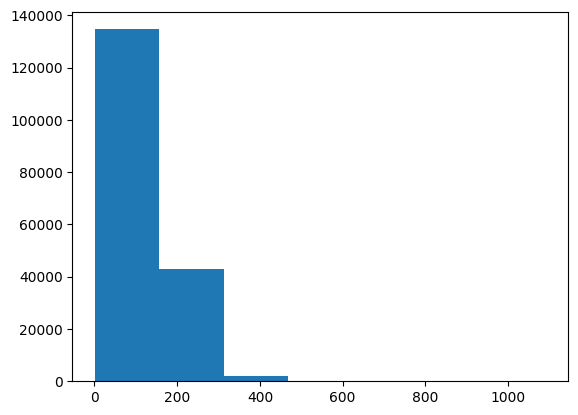

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_len,bins=7)

In [ ]:
MAX_OUTPUT_LEN = int(np.percentile(char_len,95))
print(MAX_OUTPUT_LEN,MAX_CHAR_TOKENS)

239 70


In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_CHAR_TOKENS,
                                                    standardize=None,
                                                    output_sequence_length=MAX_OUTPUT_LEN)
char_vectorizer.adapt(tf_train_data_char)
char_vocab = char_vectorizer.get_vocabulary()
char_vocab[:5]

['', '[UNK]', 'e', 't', 'i']

In [ ]:
char_embedding_layer = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                                 output_dim = 25,
                                                 mask_zero=True,
                                                 )

In [ ]:
vec = char_vectorizer(['h e l l o w  w o r l d'])
print(vec,char_embedding_layer(vec))

tf.Tensor(
[[13  2 12 12  7 21 21  7  8 12 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 239), dtype=int64) tf.Tensor(
[[[-0.02302582 -0.034732    0.00742992 ...  0.04027418  0.00676509
   -0.0078484 ]
  [-0.02326511  0.04460405  0.00842615 ...  0.04749348  0.04896029
    0.02112162]
  [ 0.04796569 -0.02458721 -0.03289639 ... 

In [ ]:
inputs_3 = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
char_vectorization_layer = char_vectorizer(inputs_3)
char_embedd_layer = char_embedding_layer(char_vectorization_layer)
conv_1d_layer_3 = tf.keras.layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embedd_layer)
avg_pooling_layer_3 = tf.keras.layers.GlobalMaxPooling1D()(conv_1d_layer_3)
outputs_3 = tf.keras.layers.Dense(total_classes,activation='softmax')(avg_pooling_layer_3)
model_3 = tf.keras.Model(inputs=inputs_3,outputs=outputs_3)
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

In [ ]:
tf_train_data_char_prefecthed = tf.data.Dataset.from_tensor_slices((tf_train_data_char,train_label_ohe))
tf_test_data_char_prefecthed = tf.data.Dataset.from_tensor_slices((tf_test_data_char,test_label_ohe))
tf_val_data_char_prefecthed = tf.data.Dataset.from_tensor_slices((tf_val_data_char,val_label_ohe))
tf_train_data_char_prefecthed = tf_train_data_char_prefecthed.batch(32).prefetch(tf.data.AUTOTUNE)
tf_test_data_char_prefecthed = tf_test_data_char_prefecthed.batch(32).prefetch(tf.data.AUTOTUNE)
tf_val_data_char_prefecthed = tf_val_data_char_prefecthed.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
hist_3 = model_3.fit(tf_train_data_char_prefecthed,
                     epochs=3,
                     batch_size=32,
                     steps_per_epoch=int(0.1*len(tf_train_data_char_prefecthed)),
                     validation_data=tf_val_data_char_prefecthed,
                     validation_steps=int(0.1*len(tf_val_data_char_prefecthed))
                     )

In [ ]:
tf_val_data_char

In [ ]:
preds_3 = model_3.predict(tf.constant(tf_test_data_char,dtype=tf.string))

In [ ]:
preds_3 = tf.argmax(preds_3,axis=1)

In [ ]:
eval_model(test_label_le,preds_3)

# **4️⃣ Multi-Modal Hybrid Model(with pretrained USE and char_level_embedding with LSTM as inputs)**

##**Making the Data ready before the Model.**

In [ ]:
combined_train_data = tf.data.Dataset.from_tensor_slices((train_data['string'],tf_train_data_char))
tf_train_label_multimodal = tf.data.Dataset.from_tensor_slices(train_label_ohe)
tf_multimodal_train_data = tf.data.Dataset.zip((combined_train_data,tf_train_label_multimodal))

combined_test_data = tf.data.Dataset.from_tensor_slices((test_data['string'],tf_test_data_char))
tf_test_label_multimodal = tf.data.Dataset.from_tensor_slices(test_label_ohe)
tf_multimodal_test_data = tf.data.Dataset.zip((combined_test_data,tf_test_label_multimodal))

combined_val_data = tf.data.Dataset.from_tensor_slices((val_data['string'],tf_val_data_char))
tf_val_label_multimodal = tf.data.Dataset.from_tensor_slices(val_label_ohe)
tf_multimodal_val_data = tf.data.Dataset.zip((combined_val_data,tf_val_label_multimodal))

tf_multimodal_train_data = tf_multimodal_train_data.batch(32).prefetch(tf.data.AUTOTUNE)
tf_multimodal_test_data = tf_multimodal_test_data.batch(32).prefetch(tf.data.AUTOTUNE)
tf_multimodal_val_data = tf_multimodal_val_data.batch(32).prefetch(tf.data.AUTOTUNE)

##**Pretrained USE model**

In [ ]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
import tensorflow_hub as hub
class PretrainedModelLayer(tf.keras.layers.Layer):
    def __init__(self, name):
        super(PretrainedModelLayer, self).__init__(name='PretrainedModelLayer')
        self.name=name
        self.model = hub.KerasLayer(use_url, trainable=False)
    def call(self, inputs):
        return self.model(inputs)
USE_inputs = tf.keras.Input(shape=[], dtype=tf.string, name='USE_input_layer')
tf_hub_embedding_layer = PretrainedModelLayer(name='pretrained_hub_layer')(USE_inputs)
USE_outputs = tf.keras.layers.Dense(128, activation='relu')(tf_hub_embedding_layer)
USE_model = tf.keras.Model(inputs=USE_inputs, outputs=USE_outputs,name='USE_model')

In [ ]:
USE_model.summary()

Model: "USE_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ USE_input_layer (InputLayer)         │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pretrained_hub_layer                 │ (None, 512)                 │               0 │
│ (PretrainedModelLayer)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,664 (256.50 KB)

 Trainable params: 65,664 (256.50 KB)

 Non-trainable params: 0 (0.00 B)

## **Char_level_embedding_model with Lstm**

In [ ]:
char_embedd_inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)

char_vectorization_layer_4 = char_vectorizer(char_embedd_inputs)

char_embedd_layer_4 = char_embedding_layer(char_vectorization_layer_4)

char_embedd_outputs = tf.keras.layers.LSTM(24)(char_embedd_layer_4)
char_embedd_model = tf.keras.Model(inputs=char_embedd_inputs,
                                   outputs=char_embedd_outputs,
                                   name="char_embedd_model")

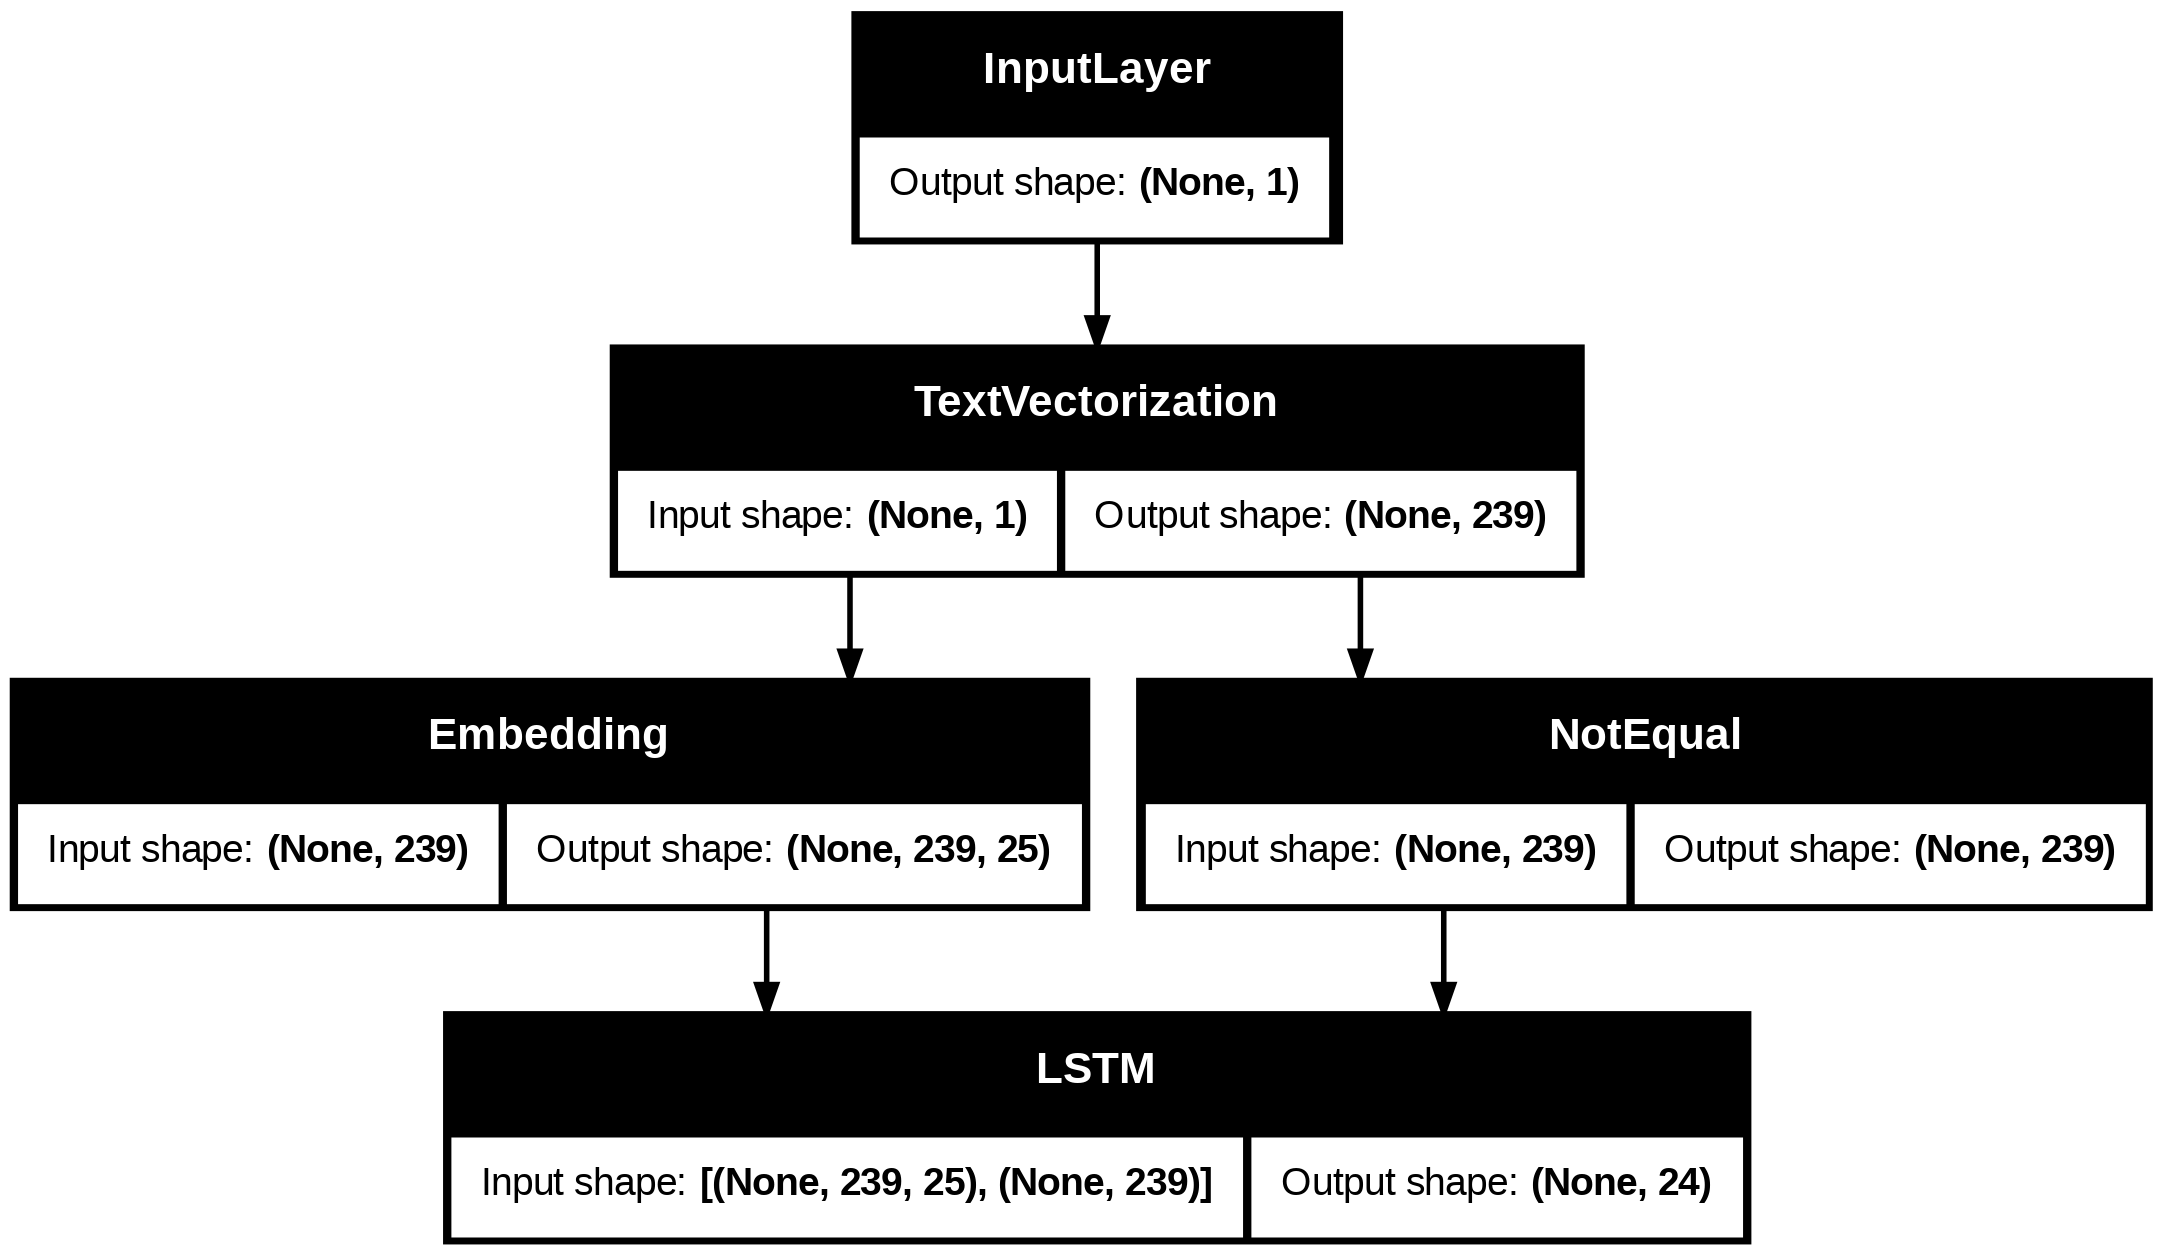

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(char_embedd_model,show_shapes=True)

##**Final combined Model**

In [ ]:
char_USE_concat = tf.keras.layers.Concatenate(name='Combined_models_input')([USE_model.output,
                                                                             char_embedd_model.output])
combined_dropout = tf.keras.layers.Dropout(0.5)(char_USE_concat)
x = tf.keras.layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(x)
outputs_4 = tf.keras.layers.Dense(total_classes,activation='softmax')(final_dropout)
model_4 = tf.keras.Model(inputs=[USE_model.input,char_embedd_model.input],
                         outputs=outputs_4)
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

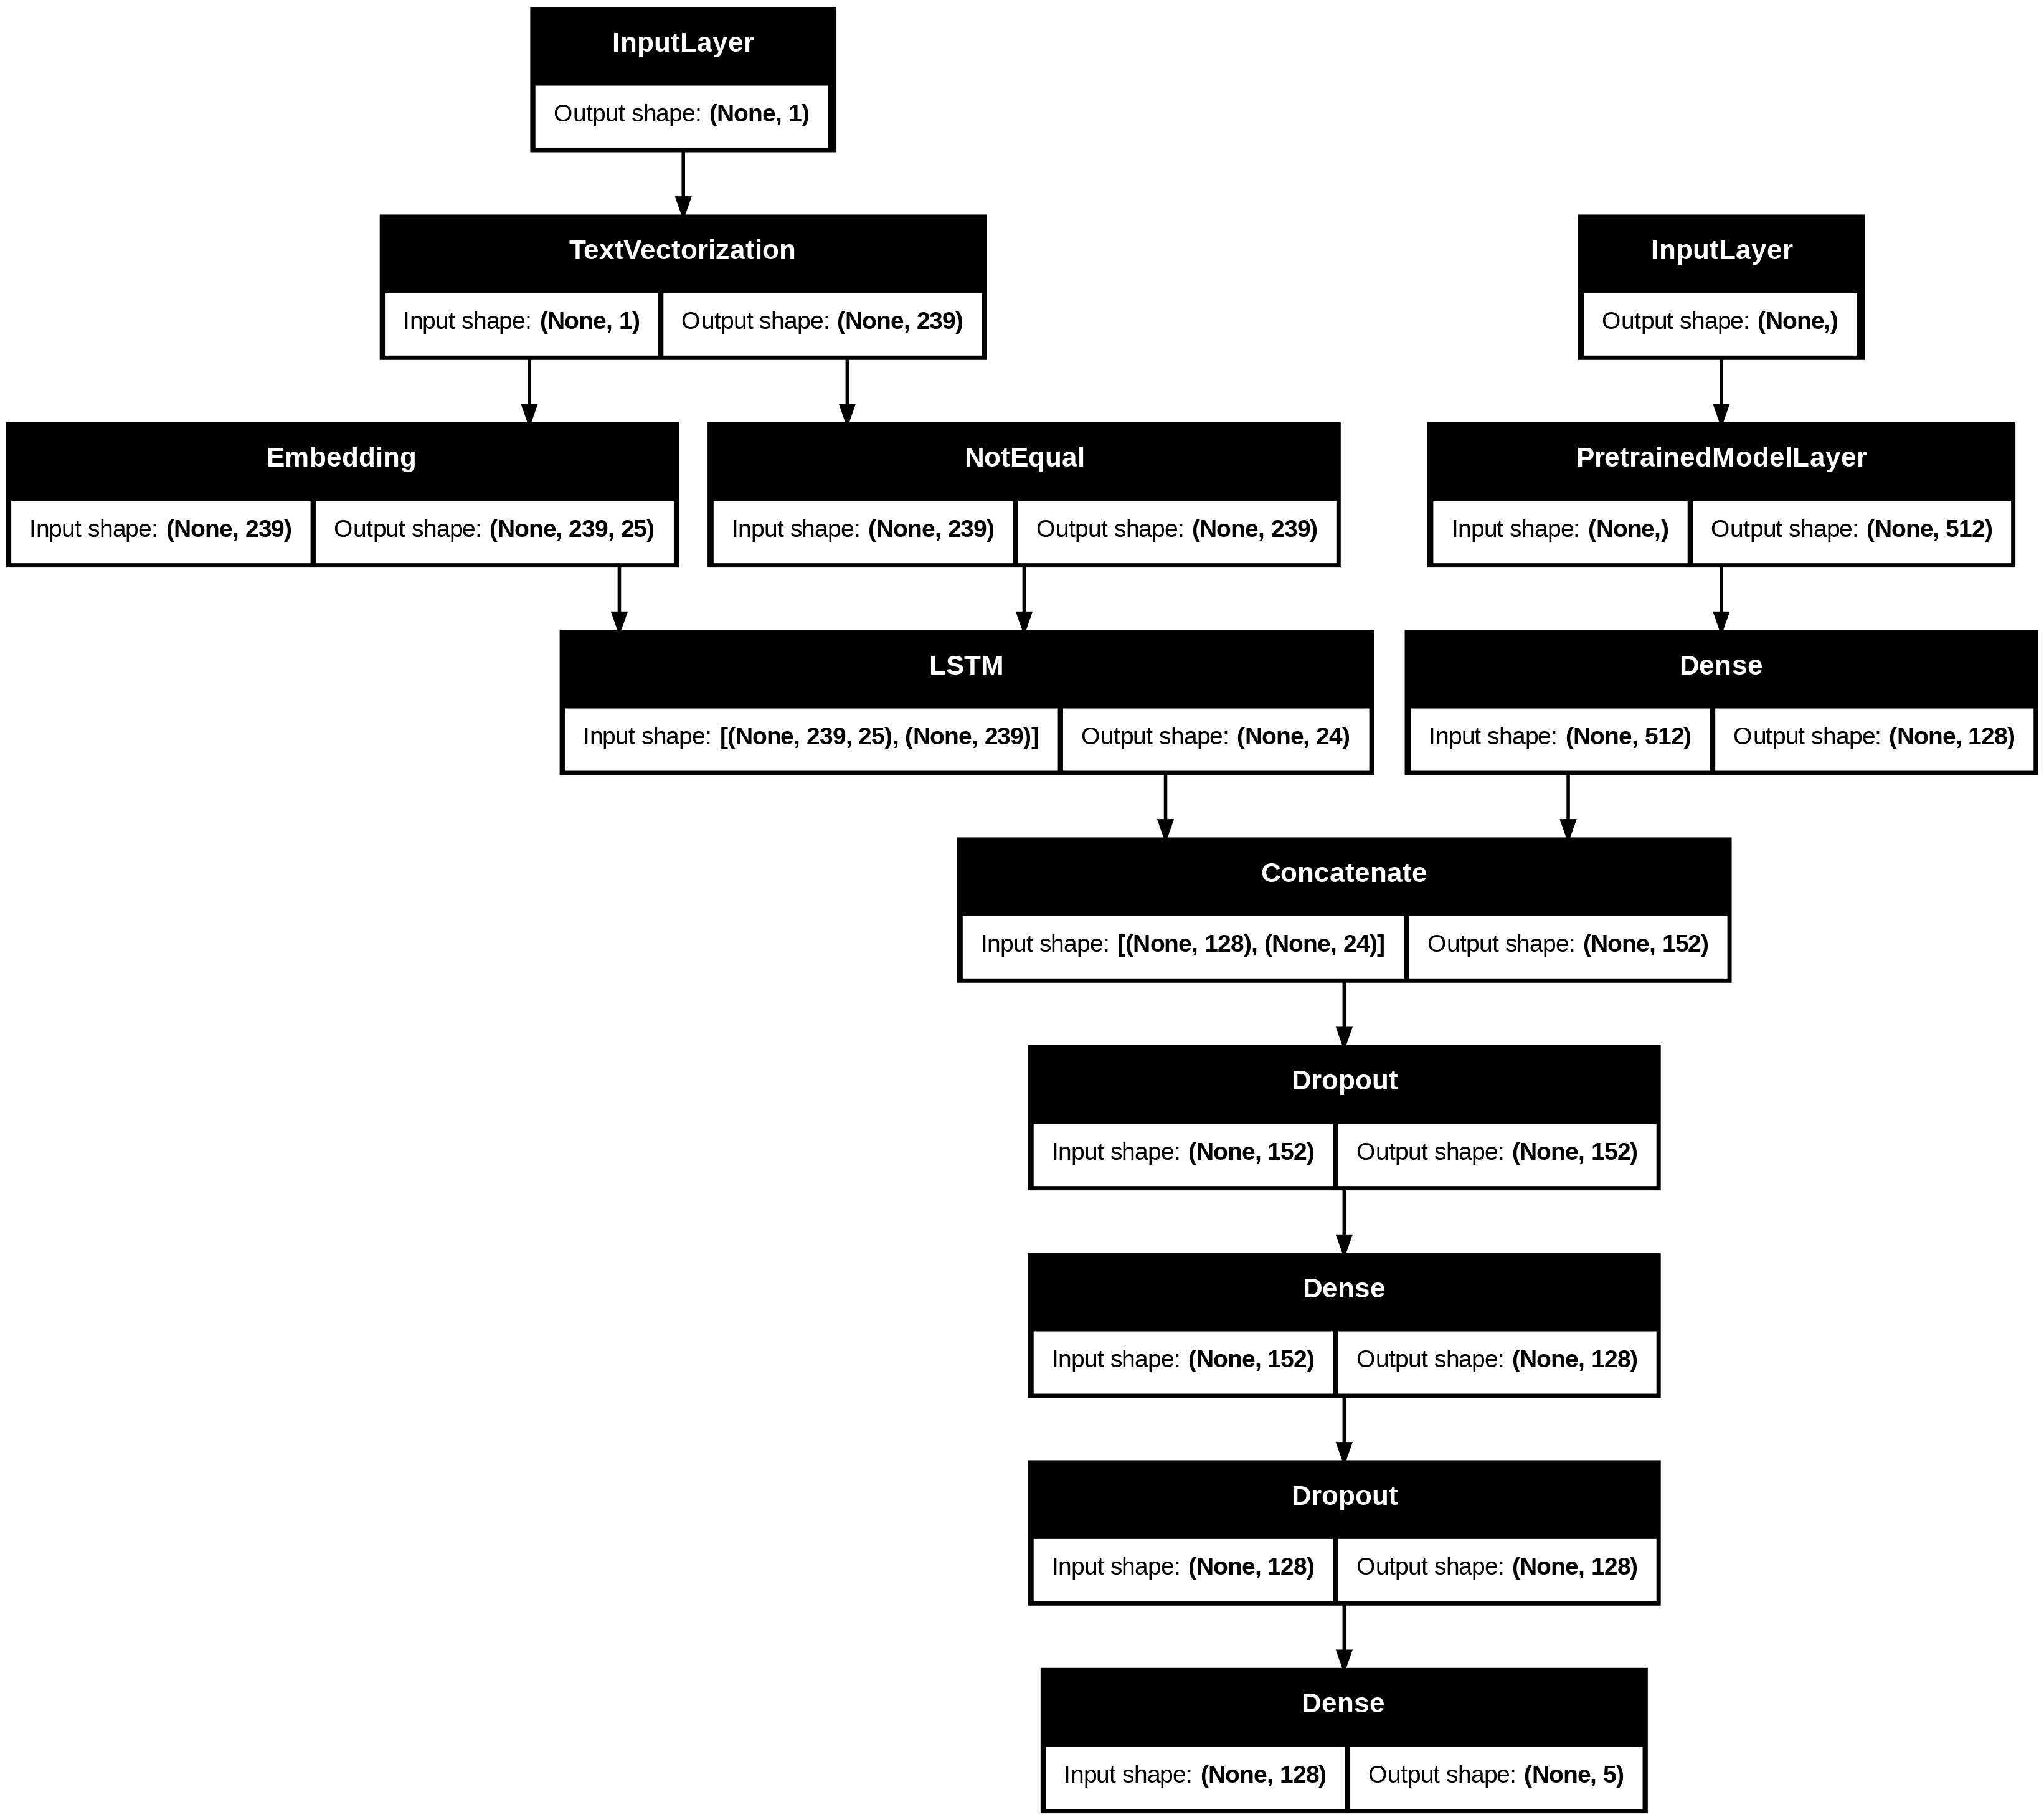

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4,to_file='model_4.png',show_shapes=True)

In [ ]:
hist_4 = model_4.fit(tf_multimodal_train_data,
            epochs = 3,
            steps_per_epoch=int(0.1*len(tf_multimodal_train_data)),
            validation_data=tf_multimodal_val_data,
            validation_steps=int(0.1*len(tf_multimodal_val_data)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.5209 - loss: 1.1435 - val_accuracy: 0.6955 - val_loss: 0.7847
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6742 - loss: 0.8363 - val_accuracy: 0.7204 - val_loss: 0.7300
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7008 - loss: 0.7833 - val_accuracy: 0.7320 - val_loss: 0.7060


In [ ]:
preds_4 = model_4.predict(tf_multimodal_val_data)

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


In [ ]:
preds_4 = tf.argmax(preds_4,axis=1)

In [ ]:
eval_model(val_label_le,preds_4)

,Metrics,Values
0,accuracy,0.727228
1,precision,0.729078
2,recall,0.727228
3,f1,0.722971


#**5️⃣ Multi_Modal Hybrid Model(Taking sequence of sentences into consideration)**

##**M5_Data_Prep**

In [ ]:
train_seq_line_number =  train_data['line_number']
test_seq_line_number = test_data['line_number']
val_seq_line_number = val_data['line_number']

In [ ]:
combined_train_data = tf.data.Dataset.from_tensor_slices((train_data['string'],tf_train_data_char,train_seq_line_number))
tf_train_label_multimodal = tf.data.Dataset.from_tensor_slices(train_label_ohe)
tf_multimodal_train_data = tf.data.Dataset.zip((combined_train_data,tf_train_label_multimodal))

combined_test_data = tf.data.Dataset.from_tensor_slices((test_data['string'],tf_test_data_char,test_seq_line_number))
tf_test_label_multimodal = tf.data.Dataset.from_tensor_slices(test_label_ohe)
tf_multimodal_test_data = tf.data.Dataset.zip((combined_test_data,tf_test_label_multimodal))

combined_val_data = tf.data.Dataset.from_tensor_slices((val_data['string'],tf_val_data_char,val_seq_line_number))
tf_val_label_multimodal = tf.data.Dataset.from_tensor_slices(val_label_ohe)
tf_multimodal_val_data = tf.data.Dataset.zip((combined_val_data,tf_val_label_multimodal))

m5_train_data = tf_multimodal_train_data.batch(32).prefetch(tf.data.AUTOTUNE)
m5_test_data = tf_multimodal_test_data.batch(32).prefetch(tf.data.AUTOTUNE)
m5_val_data = tf_multimodal_val_data.batch(32).prefetch(tf.data.AUTOTUNE)

##**Model_for_line_number**

In [ ]:
inputs_x = tf.keras.layers.Input(shape=(1,),dtype=tf.float32)
x = tf.keras.layers.Dense(128,activation='relu')(inputs_x)
outputs_x = tf.keras.layers.Dense(64,activation='relu')(x)
model_x = tf.keras.Model(inputs=inputs_x,outputs=outputs_x,name='model_x')

##**Final_Model**

In [ ]:
m4_x_concat = tf.keras.layers.Concatenate(name='model_4_and_x_layer')([USE_model.output,
                                                                        char_embedd_model.output,
                                                                        model_x.output])
combined_dropout = tf.keras.layers.Dropout(0.5)(m4_x_concat)
x = tf.keras.layers.Dense(128,activation='relu')(combined_dropout)
outputs_5 = tf.keras.layers.Dense(total_classes,activation='softmax')(x)
model_5 = tf.keras.Model(inputs=[USE_model.input,char_embedd_model.input,model_x.input],
                         outputs=outputs_5)

In [ ]:
model_5.compile(loss='CategoricalCrossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
hist_5 = model_5.fit(m5_train_data,
                     epochs=3,
                     batch_size=32,
                     steps_per_epoch=int(0.1*len(m5_train_data)),
                     validation_data=m5_val_data,
                     validation_steps=int(0.1*len(m5_val_data)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6901 - loss: 0.7964 - val_accuracy: 0.8078 - val_loss: 0.4975
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8063 - loss: 0.5060 - val_accuracy: 0.8155 - val_loss: 0.4478
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8061 - loss: 0.4935 - val_accuracy: 0.8082 - val_loss: 0.4532


In [ ]:
preds_5 = model_5.predict(m5_val_data)
preds_5 = tf.argmax(preds_5,axis=1)
eval_model(val_label_le,preds_5)

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


,Metrics,Values
0,accuracy,0.819343
1,precision,0.819659
2,recall,0.819343
3,f1,0.818886


Hence Found the best Model So Far.

#6️⃣**Last_Experiments**

In [ ]:
train_seq_line_number =  train_data['line_number']
test_seq_line_number = test_data['line_number']
val_seq_line_number = val_data['line_number']

In [ ]:
combined_train_data = tf.data.Dataset.from_tensor_slices((train_data['string'],train_seq_line_number))
tf_train_label_multimodal = tf.data.Dataset.from_tensor_slices(train_label_ohe)
tf_multimodal_train_data = tf.data.Dataset.zip((combined_train_data,tf_train_label_multimodal))

combined_test_data = tf.data.Dataset.from_tensor_slices((test_data['string'],test_seq_line_number))
tf_test_label_multimodal = tf.data.Dataset.from_tensor_slices(test_label_ohe)
tf_multimodal_test_data = tf.data.Dataset.zip((combined_test_data,tf_test_label_multimodal))

combined_val_data = tf.data.Dataset.from_tensor_slices((val_data['string'],val_seq_line_number))
tf_val_label_multimodal = tf.data.Dataset.from_tensor_slices(val_label_ohe)
tf_multimodal_val_data = tf.data.Dataset.zip((combined_val_data,tf_val_label_multimodal))

m6_train_data = tf_multimodal_train_data.batch(32).prefetch(tf.data.AUTOTUNE)
m6_test_data = tf_multimodal_test_data.batch(32).prefetch(tf.data.AUTOTUNE)
m6_val_data = tf_multimodal_val_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs_x = tf.keras.layers.Input(shape=(1,),dtype=tf.float32)
x = tf.keras.layers.Dense(128,activation='relu')(inputs_x)
outputs_x = tf.keras.layers.Dense(64,activation='relu')(x)
model_x = tf.keras.Model(inputs=inputs_x,outputs=outputs_x,name='model_x')

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectorizor_layer = text_vectorizor(inputs)
text_embedding_layer = embedd_layer(text_vectorizor_layer)
x = tf.keras.layers.Conv1D(filters = 64,kernel_size = 4,padding = 'same',activation='relu')(text_embedding_layer)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
sentece_encoder_layer = tf.keras.Model(inputs=inputs,outputs=x)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sentece_encoder_layer.output

<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_31>

In [ ]:
m6_x_concat = tf.keras.layers.Concatenate(name='model_6_and_x_layer')([sentece_encoder_layer.output,
                                                                        model_x.output])
combined_dropout = tf.keras.layers.Dropout(0.5)(m6_x_concat)
x = tf.keras.layers.Dense(128,activation='relu')(combined_dropout)
outputs_6 = tf.keras.layers.Dense(total_classes,activation='softmax')(x)

model_6 = tf.keras.Model(inputs=[sentece_encoder_layer.input,model_x.input],
                         outputs=outputs_6)
model_6.compile(loss='CategoricalCrossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

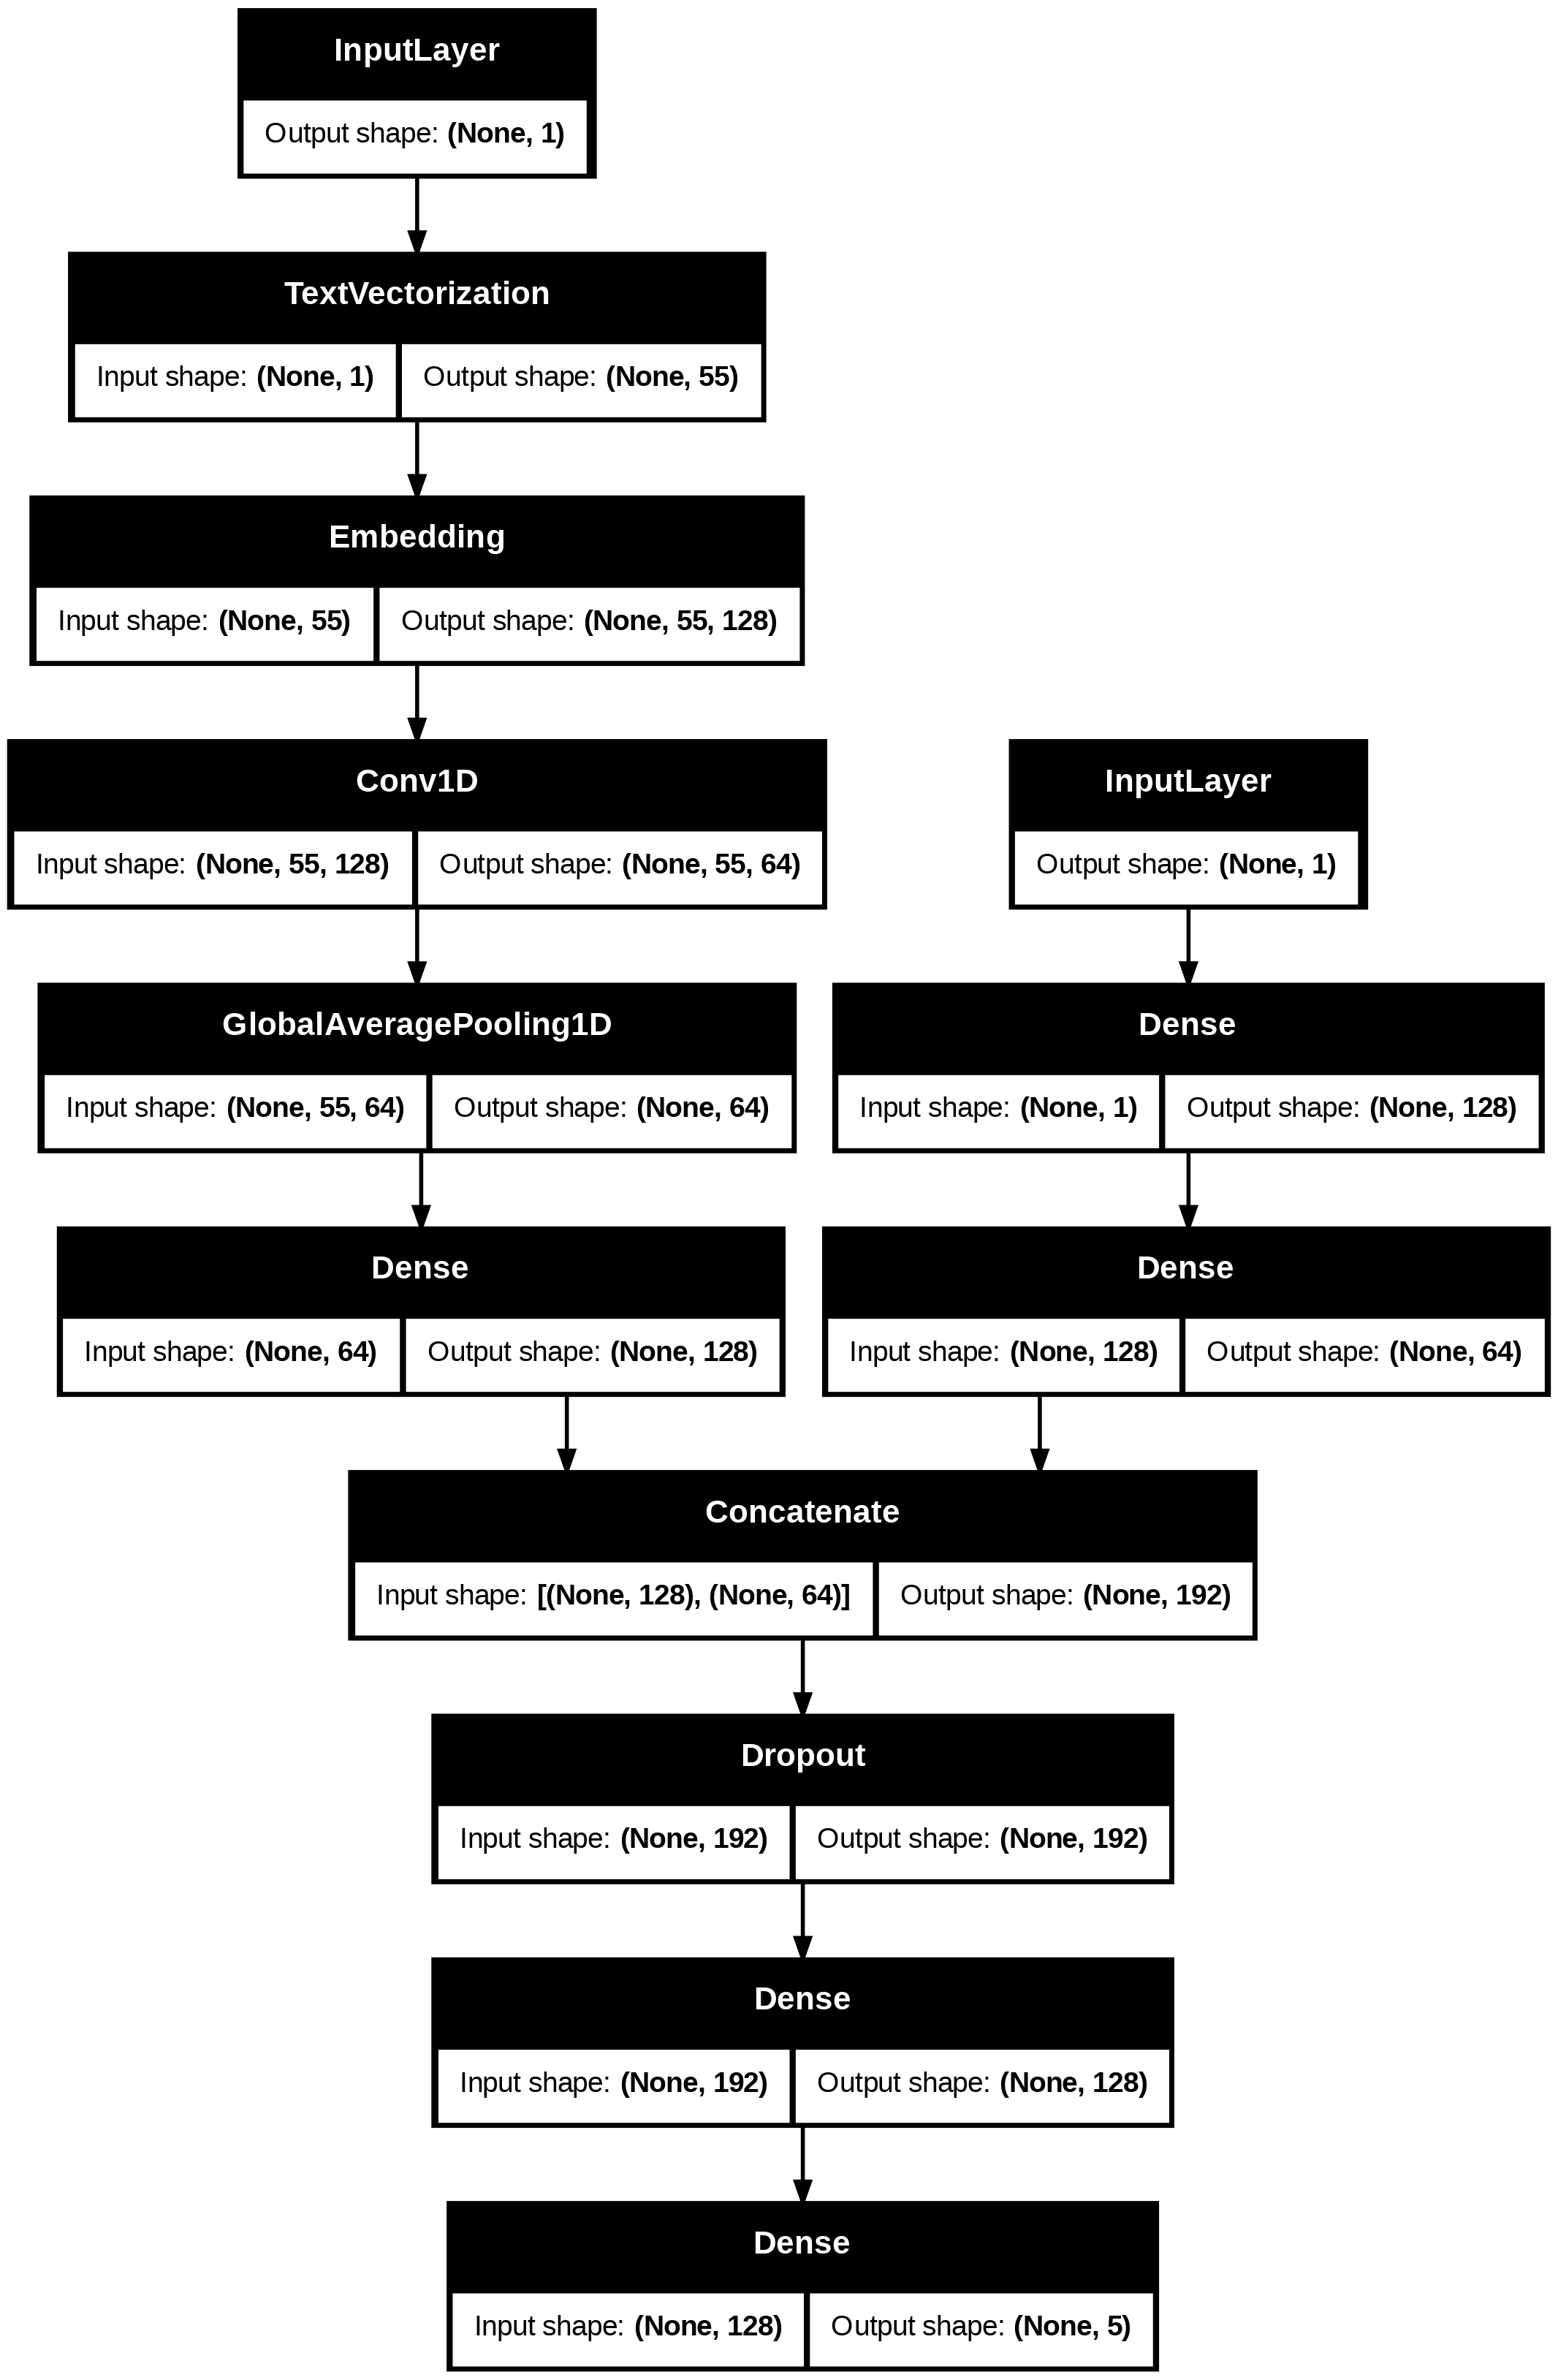

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_6,to_file='model_6.png',show_shapes=True)

In [ ]:
hist_6 = model_6.fit(m6_train_data,
                     epochs=3,
                     batch_size=32,
                     steps_per_epoch=int(0.1*len(m6_train_data)),
                     validation_data=m6_val_data,
                     validation_steps=int(0.1*len(m6_val_data)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5688 - loss: 1.0088 - val_accuracy: 0.8152 - val_loss: 0.4759
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8021 - loss: 0.5040 - val_accuracy: 0.8208 - val_loss: 0.4298
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8127 - loss: 0.4667 - val_accuracy: 0.8314 - val_loss: 0.4152


In [ ]:
preds_6 = model_6.predict(m6_val_data)
preds_6 = tf.argmax(preds_6,axis=1)
eval_model(val_label_le,preds_6)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


,Metrics,Values
0,accuracy,0.834768
1,precision,0.836654
2,recall,0.834768
3,f1,0.834078


In [ ]:
model_6.save('model_6_skimlit.keras')